In [1]:
# Standard python code
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import c, hbar, e
from scipy.special import fresnel
import sys
sys.path.insert(0,"../")
# huntstone imports

from plotting import makefig
import prop_plasma as pp
from read_data import read_data
import spectral_intensity as si
from v_x_interp import velocity_interp, position_interp

# Plotting style
plt.style.use('huntstone')
# Set parameters for reading WARGSim dumps
path   = "/media/keenan/Data_Storage/WARGSim/500dumps/"
N      = int(1e6)
nDumps = 699

beam_params = {
    'N'       : int(1e6),
    'beamE'   : 10e9, 
    'eps_n0'  : 3.0e-6,
    'beta0'   : [0.25, 0.25], 
    'alpha0'  : [0.00, 0.00],
    'rms_z'  : 0.00,
    'rms_gb0' : 0.01,
    'path'    : '/media/keenan/Data_Storage/WARGSim/',
    'B_mag'   : 5.00
}
plasma_params = {
    'n0'    : 0.34,
    'L_ft'  : 0.4,
    'hw_up' : 0.0,
    'shape' : 'Gauss'
}
my_ebeam = pp.init_beam(beam_params, plasma_params['n0'])
pwfa0    = pp.init_plasma(beam_params, plasma_params)
dumpPeriod = int(len(pwfa0.dz) / nDumps)

beta factor = 43.83
Bmag = 21.92
init eps_nx =  3.000212526031145e-06
init eps_ny =  3.00517031596688e-06


In [2]:
# Get positions and times
x = np.load("x_noGain.npy")
y = np.load("y_noGain.npy")
gb = np.load("gb_noGain.npy")
z = np.linspace(0, pwfa0.L, nDumps)
t = z / c
# Calculate proper time
dtau = np.diff(t)[0]/gb
tau  = np.zeros(nDumps)
for i in range(1, nDumps):
    tau[i] = tau[i-1] + dtau[i-1]
vx  = np.diff(x) / np.diff(tau)
vx  = np.append(vx, vx[-1])
vy  = np.diff(y) / np.diff(tau)
vy  = np.append(vy, vy[-1])
vz  = np.diff(z) / np.diff(tau)
vz  = np.append(vz, vz[-1])
vct = c * gb 
x4  = (c*t, x, y, z)
v4  = (vct, vx, vy, vz)
v   = (vx, vy, vz)
tau_int = np.linspace(tau[0], tau[-1], 1000)

In [3]:
x1n, x2n, v1n = si.get_coeffs(x4, v4, tau, tau_int)

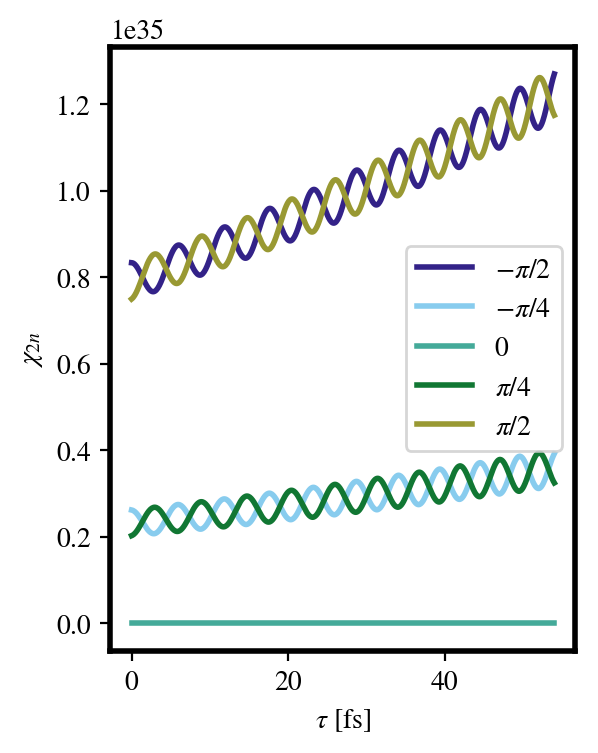

In [4]:
theta = np.array([-90, -45, 0, 45, 90]) * (np.pi / 180)
th_labs = [r'$-\pi/2$', r'$-\pi/4$', r'0', r'$\pi/4$', r'$\pi/2$']
fig, ax = makefig(xlab = r'$\tau$ [fs]', ylab = r'$\chi_{2n}$')
for i in range(len(theta)):
    s     = [0, np.sin(theta[i]), np.cos(theta[i])]
    chi1n, chi2n = si.get_chis(1e18, s, x1n, x2n, tau, plot = False)
    ax.plot(tau[0:-3]*1e15, chi2n[0:-3], label = th_labs[i])
ax.legend()
plt.show()

In [5]:
E = np.linspace(1e-3, 10, 100) * 1e3 # keV
w = (E * e)/hbar
theta = np.linspace(-5e-3, 5e-3, 100)

In [6]:
d2I = np.zeros((len(w), len(theta)))
for i in range(len(w)):
    w_use = w[i]
    if (i+1)%10==0:
        print(i+1)
    for j in range(len(theta)):
        d2I[i,j] = si.get_intensity(theta[i], w_use, x4, v4, tau, tau_int, dtau)

10
20
30
40
50
60
70
80
90
100


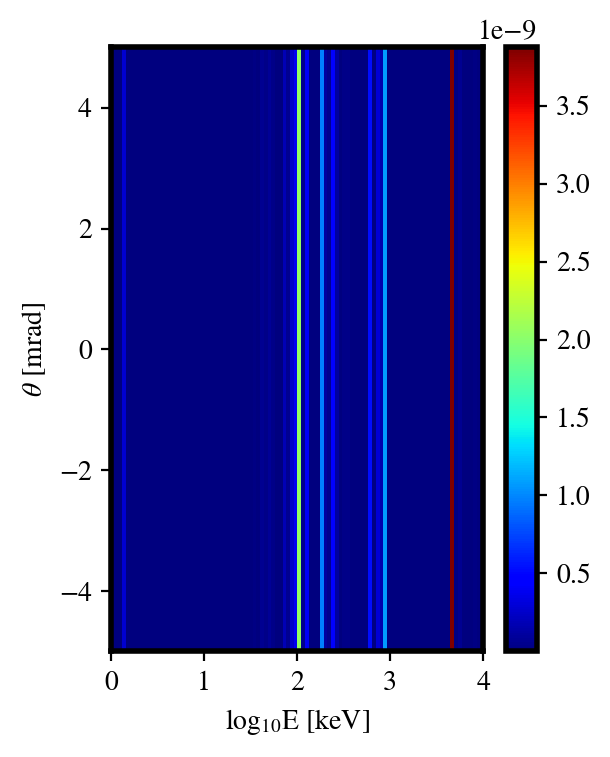

In [7]:
d2I_plot = d2I #/ np.amax(d2I)
ext      = np.array([min(np.log10(E)), max(np.log10(E)), min(theta)*1e3, max(theta)*1e3])
%matplotlib inline
fig, ax = makefig(xlab = r'log$_{10}$E [keV]', ylab = r'$\theta$ [mrad]')
img = ax.imshow(np.transpose(d2I_plot), extent = ext, aspect = 'auto', cmap = 'jet')
cb = plt.colorbar(mappable = img)
plt.show()